In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.style as style
style.use('ggplot')

from scipy import stats
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers, activations
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import models
from sklearn import preprocessing, decomposition



RANDOM_SEED = 42

Using TensorFlow backend.


In [2]:
df = pd.read_excel("Dados_Anomalias.xlsx")

df.head()

,Cyc Water,Mill Water,Mill Feed,PSI,Cyc Pressure (psi),Mill Power,Anomaly
0,223.812274,19.186624,202.823357,62.541316,0.612988,3335.920588,0
1,225.184535,19.186649,202.739986,62.434876,0.612922,3339.722789,0
2,225.185704,19.187493,202.273536,72.517052,0.615369,3344.942698,0
3,225.184088,19.187664,202.580639,80.587775,0.613380,3344.121925,0
4,223.329328,18.320862,202.743300,72.557990,0.606886,3352.125359,0


In [3]:
def show_pca_df(df):
    x = df[df.columns[0:5]].to_numpy()
    y = df[df.columns[5]].to_numpy()

    x = preprocessing.MinMaxScaler().fit_transform(x)
    pca = decomposition.PCA(n_components=3)
    pca_result = pca.fit_transform(x)
    print(pca.explained_variance_ratio_)

    pca_df = pd.DataFrame(data=pca_result, columns=['pc_1', 'pc_2', 'pc_3'])
    pca_df = pd.concat([pca_df, pd.DataFrame({'label': y})], axis=1)

    ax = Axes3D(plt.figure(figsize=(8, 8)))
    ax.scatter(xs=pca_df['pc_1'], ys=pca_df['pc_2'], zs=pca_df['pc_3'], c=pca_df['label'], s=25)
    ax.set_xlabel("PC_1")
    ax.set_ylabel("PC_2")
    ax.set_zlabel("PC_3")
    plt.show()

[0.93113291 0.04323289 0.01668867]


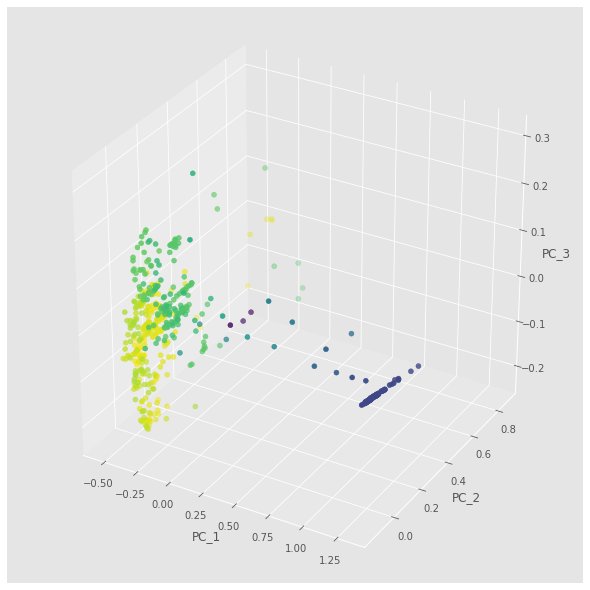

In [4]:
show_pca_df(df)

In [5]:
from sklearn.preprocessing import StandardScaler

df['Cyc Water'] = StandardScaler().fit_transform(df['Cyc Water'].values.reshape(-1, 1))
df['Mill Water'] = StandardScaler().fit_transform(df['Mill Water'].values.reshape(-1, 1))
df['Mill Feed'] = StandardScaler().fit_transform(df['Mill Feed'].values.reshape(-1, 1))
#df['PSI'] = StandardScaler().fit_transform(df['PSI'].values.reshape(-1, 1))
df['Cyc Pressure (psi)'] = StandardScaler().fit_transform(df['Cyc Pressure (psi)'].values.reshape(-1, 1))
df['Mill Power'] = StandardScaler().fit_transform(df['Mill Power'].values.reshape(-1, 1))

In [6]:
df = np.array(df)

In [7]:
x_data = df[:,0:6]
y_data = df[:,6]

In [8]:
input_dim = x_data.shape[1]
print(input_dim)

6


In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.5, random_state=5)

In [10]:
def build_model():
#Creating the model
    model = Sequential()

    #Input and Hidden Layers
    model.add(Dense(8, activation='relu',
                               input_shape=(x_train.shape[1],)))
    model.add(Dense(64, activation = 'relu')) 
    model.add(Dense(32, activation = 'relu'))

    #Output Layer
    model.add(Dense(1, activation = 'sigmoid'))
    
    #Adjusting operational parameters
    model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ['accuracy'])
   
    return model

In [11]:
from tensorflow.keras import backend as K
K.clear_session()

In [12]:
model = build_model()
#Training the model
history = model.fit(x_train, y_train, epochs = 100, batch_size=2, validation_data = (x_test, y_test), verbose = 0)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 56        
_________________________________________________________________
dense_1 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 2,745
Trainable params: 2,745
Non-trainable params: 0
_________________________________________________________________


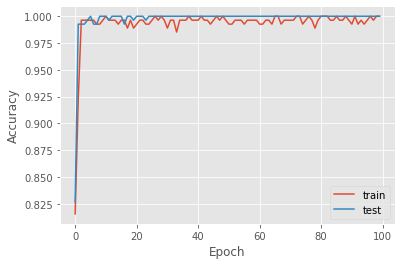

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

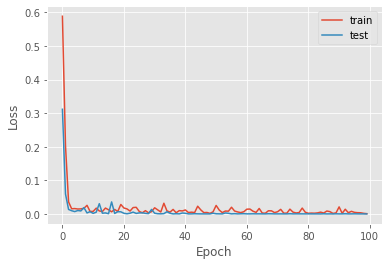

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [16]:
def normaliza(x_new):
    
    x_new[0][0] -= 183.4774
    x_new[0][1] -= 13.9945
    x_new[0][2] -= 158.544
    x_new[0][3] -= 63.351
    x_new[0][4] -= 0.3981
    x_new[0][5] -= 3069.158

    x_new[0][0] /= 81.18886
    x_new[0][1] /= 6.6099
    x_new[0][2] /= 74.7123
    x_new[0][3] /= 2.888
    x_new[0][4] /= 0.19312
    x_new[0][5] /= 293.1745

    return x_new

In [17]:
x_test = []
y_test = []

x_test.append(np.array([[74.8505,5.3593,55.2195,68.9348,0.1255,2658.6988]])) #Anomalia
x_test.append(np.array([[230.7948,19.0728,199.5670,61.9917,0.4750,3096.6288]])) #Normal
x_test.append(np.array([[9.7484,0.2655,0.2059,62.4160,0.0069,2507.2545]])) #Anomalia
x_test.append(np.array([[220.0886,15.3509,181.2426,64.7993,0.4114,3074.2701]])) #Normal

        
for i in range(0,4):
    
    y_test.append(model.predict(normaliza(x_test[i])))
    print("X=%s\nY=%s \n" % (x_test[i][0], y_test[i][0]))

X=[-1.33795326 -1.30640403 -1.38296505  1.93344875 -1.41155758 -1.40005082]
Y=[0.9597194] 

X=[ 0.58280656  0.76828696  0.5490796  -0.47067175  0.39819801  0.09370119]
Y=[0.00070873] 

X=[-2.13981327 -2.07703596 -2.11930432 -0.32375346 -2.02568351 -1.91661792]
Y=[0.9908426] 

X=[0.45093871 0.20520734 0.30381343 0.50148892 0.0688691  0.01743706]
Y=[0.02641961] 

